C:\Users\weerapat.sa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\weerapat.sa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


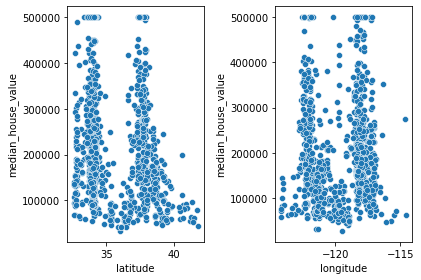

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
# อ่านไฟล์ข้อมูล
df = pd.read_csv('./Data/housing.csv')
# แบ่งข้อมูลเป็น test, train
(df_train,df_test) =train_test_split(df.copy(), test_size=0.2)
fig, axes = plt.subplots(1,2)
sns.scatterplot('latitude','median_house_value',data=df_train.sample(1000),ax=axes[0])
sns.scatterplot('longitude','median_house_value',data=df_train.sample(1000),ax=axes[1])
fig.tight_layout()

In [47]:
?sns.scatterplot

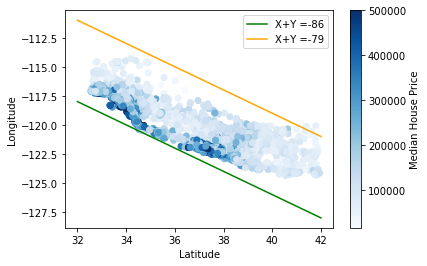

In [48]:
plt.scatter(df_train['latitude'],df_train['longitude'],c = df_train['median_house_value'],cmap= 'Blues')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
cb = plt.colorbar()
cb.set_label("Median House Price")
x = np.linspace(32, 42, 1000)
plt.plot(x,-86-x,label = 'X+Y =-86',color='green')
plt.plot(x,-79-x,label = 'X+Y =-79',color='orange')
plt.legend()

<AxesSubplot:xlabel='diagonal', ylabel='median_house_value'>

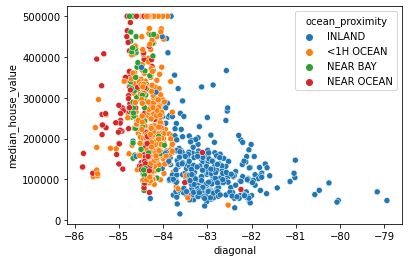

In [50]:
df_train['diagonal'] =df_train['latitude']+df_train['longitude']
df_test['diagonal'] =df_test['latitude']+df_test['longitude']
sns.scatterplot(x='diagonal',y='median_house_value',data=df_train.sample(1000),hue='ocean_proximity')

C:\Users\weerapat.sa\AppData\Local\Temp/ipykernel_7376/3714721829.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


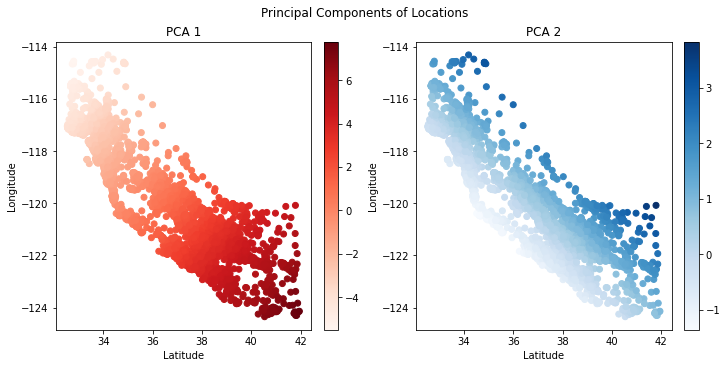

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_location = df_train[['latitude','longitude']]
pca_fit =pca.fit(train_location)
df_train[['PCA_1','PCA_2']]= pca_fit.transform(train_location)
test_location = df_test[['latitude','longitude']]
df_test[['PCA_1','PCA_2']]= pca_fit.transform(test_location)


fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout= True,figsize=(10,5))
fig.suptitle('Principal Components of Locations')
ax1.title.set_text('PCA 1')
plot1 = ax1.scatter(df_train['latitude'],df_train['longitude'],c = df_train['PCA_1'],cmap= 'Reds')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')
plt.colorbar(plot1,ax=ax1)
ax2.title.set_text('PCA 2')
plot2 = ax2.scatter(df_train['latitude'],df_train['longitude'],c = df_train['PCA_2'],cmap= 'Blues')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')
plt.colorbar(plot2,ax=ax2)
fig.show()

In [6]:
''' Plot Two Geopandas Plots Side by Side '''
# defining a simple plot function, input list containing features of names found in dataframe
def plotTwo(df,lst):
    
    # load california from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)
    
    # Create a geopandas geometry feature; input dataframe should contain .longtitude, .latitude
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude,df.latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944) # related to view

    ii=-1
    fig,ax = plt.subplots(1,2,figsize=(21,6),subplot_kw={'projection': proj})
    for i in lst:

        ii+=1
        tgdf = gdf.sort_values(by=i,ascending=True) 
        gplt.polyplot(cali,projection=proj,ax=ax[ii]) # the module already has california 
        gplt.pointplot(tgdf,ax=ax[ii],hue=i,cmap='plasma',legend=True,alpha=1.0,s=3) # 
        ax[ii].set_title(i)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)
plotTwo(df,['population','median_income'])

NameError: name 'gpd' is not defined

In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
